Example 06

Solution of the Poisson equation in 2D

$$
k_i \nabla^2 u = f
$$

with $k_i$ discontinuous due to materials with different properties, but with $u$ continuous.

# Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp

plt.style.use(["seaborn-v0_8-darkgrid", "seaborn-v0_8-colorblind", "seaborn-v0_8-talk"])
plt.rcParams["legend.frameon"] = True
plt.rcParams["legend.shadow"] = True
plt.rcParams["legend.framealpha"] = 0.1

import calfem.geometry as cfg
import calfem.mesh as cfm
import calfem.vis_mpl as cfv

from scipy.sparse.linalg import spsolve

# Geometry

First, we define the geometry of the domain using the `calfem-python` library.

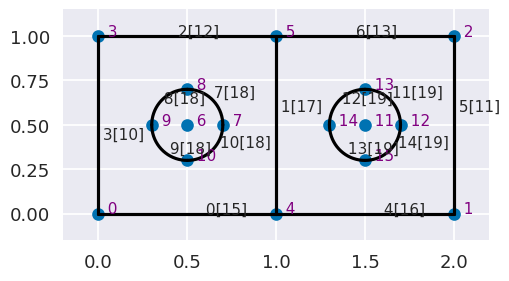

In [2]:
g = cfg.Geometry()

# points
#   corners
g.point([0,0])
g.point([2,0])
g.point([2,1])
g.point([0,1])

#   interface
g.point([1,0])
g.point([1,1])

#   left-circle
g.point([0.5,0.5])
g.point([0.7,0.5])
g.point([0.5,0.7])
g.point([0.3,0.5])
g.point([0.5,0.3])

#   right-circle
g.point([1.5,0.5])
g.point([1.7,0.5])
g.point([1.5,0.7])
g.point([1.3,0.5])
g.point([1.5,0.3])

# lines
left_marker = 10
right_marker = 11
left_top_marker = 12
right_top_marker = 13
left_bottom_marker = 15
right_bottom_marker = 16
interface_marker = 17
left_circ_mark = 18
right_circ_mark = 19

#   left-half
g.spline([0,4], marker=left_bottom_marker)
g.spline([4,5], marker=interface_marker)
g.spline([5,3], marker=left_top_marker)
g.spline([3,0], marker=left_marker)

#   right-half
g.spline([4,1], marker=right_bottom_marker)
g.spline([1,2], marker=right_marker)
g.spline([2,5], marker=right_top_marker)

#   left-circle
g.circle([7,6,8], marker=left_circ_mark)
g.circle([8,6,9], marker=left_circ_mark)
g.circle([9,6,10], marker=left_circ_mark)
g.circle([10,6,7], marker=left_circ_mark)

#   right-circle
g.circle([12,11,13], marker=right_circ_mark)
g.circle([13,11,14], marker=right_circ_mark)
g.circle([14,11,15], marker=right_circ_mark)
g.circle([15,11,12], marker=right_circ_mark)

# surfaces
left_half_mark = 0
right_half_mark = 1
left_circ_surf_mark = 2
#   left-half
g.surface(outer_loop=[0,1,2,3], holes=[[7,8,9,10]], marker=left_half_mark)
#   left-circle
g.surface([7,8,9,10], marker=left_circ_surf_mark)
#   right-half
g.surface([4,5,6,1], [[11,12,13,14]], marker=right_half_mark)

# geometry plot
plt.figure(figsize=(8,3))
cfv.draw_geometry(g,draw_axis=True)

# Mesh

From the geometry, `calfem` also generates the mesh.

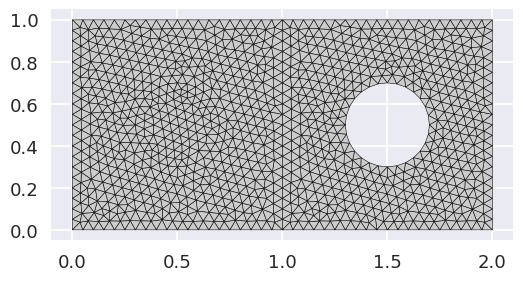

In [3]:
mesh = cfm.GmshMesh(g,el_size_factor=0.05)

coords, edof, dofs, bdofs, elementmarkers = mesh.create()
verts, faces, vertices_per_face, is_3d = cfv.ce2vf(
    coords,
    edof,
    mesh.dofs_per_node,
    mesh.el_type
)

plt.figure(figsize=(8,3))
cfv.draw_mesh(
    coords=coords,
    edof=edof,
    dofs_per_node=mesh.dofs_per_node,
    el_type=mesh.el_type,
    filled=True
)

In [4]:
coords.shape

(1073, 2)

# Identify the indices of the different boundaries and interfaces

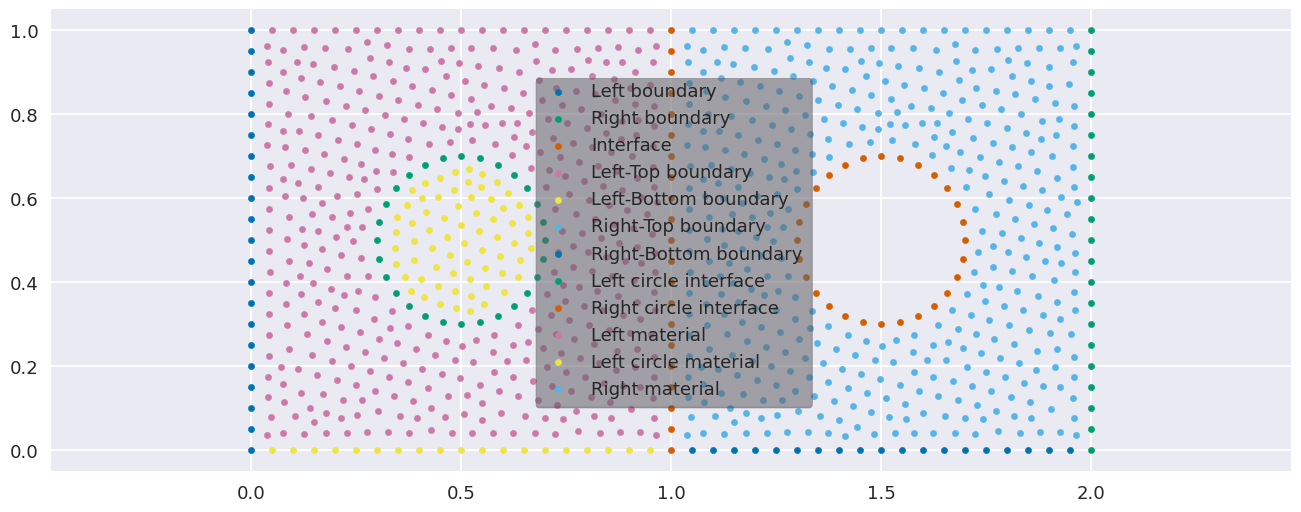

In [5]:
# boundaries
left_nodes = np.asarray(bdofs[left_marker]) - 1

right_nodes = np.asarray(bdofs[right_marker]) - 1

interface_nodes = np.asarray(bdofs[interface_marker]) - 1

left_top_nodes = np.asarray(bdofs[left_top_marker]) - 1
left_top_nodes = np.setdiff1d(left_top_nodes, [5,3])

left_bottom_nodes = np.asarray(bdofs[left_bottom_marker]) - 1
left_bottom_nodes = np.setdiff1d(left_bottom_nodes, [0,4])

right_bottom_nodes = np.asarray(bdofs[right_bottom_marker]) - 1
right_bottom_nodes = np.setdiff1d(right_bottom_nodes, [4,1])

right_top_nodes = np.asarray(bdofs[right_top_marker]) - 1
right_top_nodes = np.setdiff1d(right_top_nodes, [2,5])

left_circ_nodes = np.asarray(bdofs[left_circ_mark]) - 1

right_circ_nodes = np.asarray(bdofs[right_circ_mark]) - 1

boundary_nodes = np.hstack((
    left_nodes,
    right_nodes,
    interface_nodes,
    left_top_nodes,
    left_bottom_nodes,
    right_top_nodes,
    right_bottom_nodes,
    left_circ_nodes,
    right_circ_nodes
))

# interior nodes
elementmarkers = np.asarray(elementmarkers)

left_half_nodes = faces[elementmarkers == left_half_mark]
left_half_nodes = left_half_nodes.flatten()
left_half_nodes = np.setdiff1d(left_half_nodes, boundary_nodes)

left_circ_mat_nodes = faces[elementmarkers == left_circ_surf_mark]
left_circ_mat_nodes = left_circ_mat_nodes.flatten()
left_circ_mat_nodes = np.setdiff1d(left_circ_mat_nodes, boundary_nodes)

right_half_nodes = faces[elementmarkers == right_half_mark]
right_half_nodes = right_half_nodes.flatten()
right_half_nodes = np.setdiff1d(right_half_nodes, boundary_nodes)

# plotting
plt.figure(figsize=(16,6))
boundaries_to_plot = (
    left_nodes,
    right_nodes,
    interface_nodes,
    left_top_nodes,
    left_bottom_nodes,
    right_top_nodes,
    right_bottom_nodes,
    left_circ_nodes,
    right_circ_nodes,
    left_half_nodes,
    left_circ_mat_nodes,
    right_half_nodes
)
labels_to_plot = (
    "Left boundary",
    "Right boundary",
    "Interface",
    "Left-Top boundary",
    "Left-Bottom boundary",
    "Right-Top boundary",
    "Right-Bottom boundary",
    "Left circle interface",
    "Right circle interface",
    "Left material",
    "Left circle material",
    "Right material"
)
for b,label in zip(boundaries_to_plot, labels_to_plot):
    plt.scatter(coords[b,0], coords[b,1], label=label, s=20)

plt.axis("equal")
plt.legend(loc="center")

# Testing normal vectors

Normal vectors are computed for Neumann boundaries and interfaces using the `normal_vectors` function from the `GFDMI` module, which handles this computation automatically. Here’s an example of how to use it.

(np.float64(1.28),
 np.float64(1.72),
 np.float64(0.27999999999999997),
 np.float64(0.72))

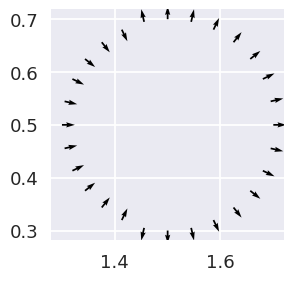

In [6]:
from GFDMI import normal_vectors

right_circ_normal_vectors = normal_vectors(right_circ_nodes, coords)

plt.figure(figsize=(3,3))
plt.quiver(
    coords[right_circ_nodes,0],
    coords[right_circ_nodes,1],
    right_circ_normal_vectors[:,0],
    right_circ_normal_vectors[:,1]
)
plt.axis("equal")

# Problem parameters

In [7]:
# coeffitients L = [A, B, C, D, E, F] in differential operator
# Au + Bu_x + Cu_y + Du_{xx} + Eu_{xy} + Fu_{yy}
L = np.array([0,0,0,1,0,1])
# permeability / conductivity
k_sand = lambda p: 1
k_rock = lambda p: 0.3
k_rock_circ = lambda p: 0.3
# source
source = lambda p: 0
# boundaries conditions
neumann_cond = lambda p: 0
left_dirichlet = lambda p: 1
right_dirichlet = lambda p: 0

# interface flux. u_n|_{M0} - u_n|_{M1} = beta
beta = lambda p: 0

# interior nodes, boundaries, and interfaces assembled as dictionaries
materials = {}
materials["sand"] = [k_sand, left_half_nodes]
materials["rock"] = [k_rock, right_half_nodes]
materials["rock_circ"] = [k_rock_circ, left_circ_mat_nodes]

# neumann boundaries
neumann = {}
neumann["left_top"] = [k_sand, left_top_nodes, neumann_cond]
neumann["left_bottom"] = [k_sand, left_bottom_nodes, neumann_cond]
neumann["right_top"] = [k_rock, right_top_nodes, neumann_cond]
neumann["right_bottom"] = [k_rock, right_bottom_nodes, neumann_cond]

# dirichlet boundaries
dirichlet = {}
dirichlet["izq"] = [left_nodes, left_dirichlet]
dirichlet["der"] = [right_nodes, right_dirichlet]
dirichlet["right_circle"] = [right_circ_nodes, lambda p: 0.2]

# interfaces
interfaces = {}
interfaces["left_circle"] = [
    k_sand,
    k_rock_circ,
    left_circ_nodes,
    beta,
    left_half_nodes,
    left_circ_mat_nodes
]
interfaces["line"] = [
    k_sand,
    k_rock,
    interface_nodes,
    beta,
    left_half_nodes,
    right_half_nodes
]

# Problem solution

For problems with a continuous solution $u$ ($u_{M_0} - u_{M_1} = \alpha$, with $\alpha = 0$), it is preferable to use the `create_system_K_F_cont_U` function from the `GFDMI` module.

In [8]:
from GFDMI import create_system_K_F_cont_U

K,F = create_system_K_F_cont_U(
    p=coords,
    triangles=faces,
    L=L,
    source=source,
    materials=materials,
    neumann_boundaries=neumann,
    dirichlet_boundaries=dirichlet,
    interfaces=interfaces
)

U = spsolve(K,F)

# Plotting solution

In [45]:
right_circ_nodes

array([ 10,  11,  12,  13, 171, 172, 173, 174, 175, 176, 177, 178, 179,
       180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192,
       193, 194])

(np.float64(0.0), np.float64(2.0), np.float64(0.0), np.float64(1.0))

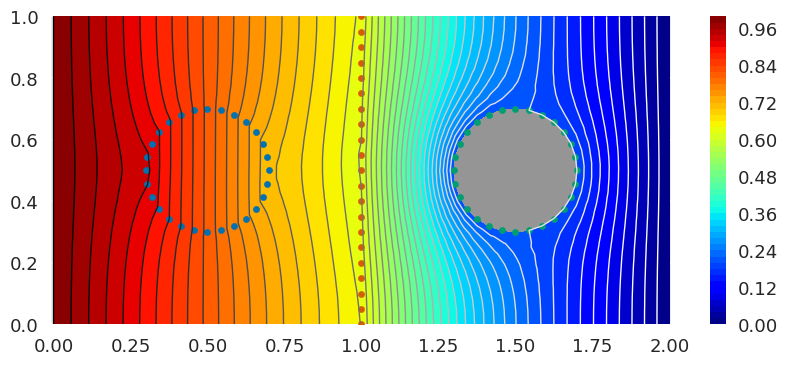

In [62]:
plt.figure(figsize=(10,4))
plt.tricontourf(coords[:,0], coords[:,1], U, levels=50, cmap="jet")
plt.colorbar()
plt.tricontour(coords[:,0], coords[:,1], U, levels=50, linewidths=1)
# gray circle
plt.tricontourf(
    coords[right_circ_nodes,0],
    coords[right_circ_nodes,1],
    U[right_circ_nodes]
)

# scatter plot for interfaces
interfaces_to_plot = (
    left_circ_nodes,
    right_circ_nodes,
    interface_nodes
)
for b in interfaces_to_plot:
    plt.scatter(coords[b,0], coords[b,1], s=20)

plt.axis("equal")

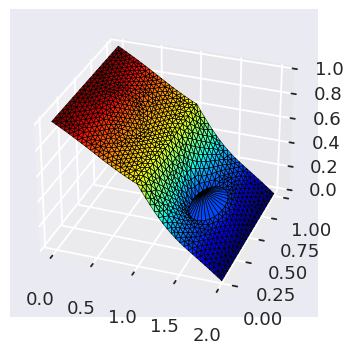

In [61]:
fig = plt.figure(figsize=(4,4))
ax = plt.axes(projection="3d")
ax.plot_trisurf(coords[:,0], coords[:,1], U, cmap="jet")
ax.plot_trisurf(coords[:,0], coords[:,1], U, edgecolor="k", alpha=0)
ax.view_init(30,-70)
